In [1]:
from schemas.output_parser import OutputStructure
from prompts.agent_prompt import CODEX_SYS
from prompts.human_request_prompt import USER_PROMPT
from dotenv import load_dotenv, find_dotenv
from states.MainState import MainState
from langchain_openai import ChatOpenAI
from langgraph.graph import START, StateGraph, END
from langchain_core.messages import HumanMessage, SystemMessage
import os
import pandas as pd
import time
from IPython.display import Image, display
# from langgraph.constants import Send

In [2]:
_ = load_dotenv(find_dotenv())

api_openai = os.getenv('OPENAI_API_KEY')
if api_openai:
    print('OpenAI API loaded.')
else:
    print('missing api key: OPEN_API_KEY')

OpenAI API loaded.


In [3]:
llm = ChatOpenAI(
    model="gpt-4.1",
    temperature=0.0
)
agent = llm.with_structured_output(OutputStructure)

In [4]:
def process_data_cluster(state: MainState):
    batch_package = []
    cluster_path = state["cluster_url"]
    df = pd.read_csv(cluster_path)
    buggy = list(df["buggy"])
    fixed = list(df["fixed"])
    
    for index, _ in enumerate(fixed):
    # for index, _ in enumerate(range(5)):
        human_prompt = USER_PROMPT.format(fixed_code=fixed[index], buggy_code=buggy[index])
        batch_package.append([SystemMessage(CODEX_SYS), HumanMessage(human_prompt)])

    return {"pair_tp_list": batch_package, "total_requests_from_df": len(batch_package), "current_offset": 0}

In [5]:
def split_data_process_for_batch(state: MainState):
    offset = state["current_offset"]
    size = 50
    total_prompts = state["total_requests_from_df"]
    limit_index = min(offset + size, total_prompts)
    
    print(f"\n--- 2. Processando lote: {offset} a {limit_index} de {total_prompts} ---")
    batch_to_process = state["pair_tp_list"][offset : limit_index]
    
    return {
        "sliced_for_batch": batch_to_process, 
        "current_offset": limit_index     
        }


In [6]:
def agent_attempt_1(state:MainState):
    batch_list= state["sliced_for_batch"]
    all_results_from_llm = agent.batch(batch_list, config={"max_concurrency": 50})
    clean_results = [res.mut_op_list for res in all_results_from_llm]

    return {"gpt_response": clean_results}   
    

In [ ]:
def async_send_conditional(state: MainState):
    async_list = []
    batch_package = state["pair_tp_list"]
    for list in batch_package:
        async_list.append(Send("Run Agent", {"tp_request": list}))
    return async_list

In [7]:
def loop_batch_conditional(state:MainState):
    offset = state["current_offset"]
    total_requests = state["total_requests_from_df"]
    if offset >= total_requests:
        return "Save DF"
    return "Batch Slicing"


In [8]:
def save_dataframe(state:MainState):
    cluster_id = state["cluster"]
    cluster_path = state["cluster_url"]
    new_df = pd.read_csv(cluster_path)
    # new_df = pd.DataFrame()
    new_df["attempt_1_results"] = state["gpt_response"]
    new_df.to_csv(f"results_{cluster_id}_from_attempt1.csv", sep=',', index=False)
    

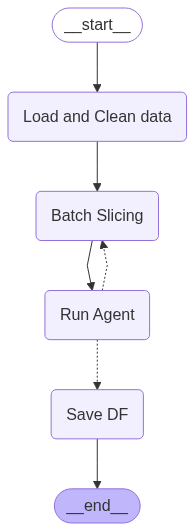

In [9]:
builder = StateGraph(MainState)

builder.add_node("Load and Clean data", process_data_cluster)
builder.add_node("Batch Slicing", split_data_process_for_batch)
builder.add_node("Run Agent", agent_attempt_1)
builder.add_node("Save DF", save_dataframe)

builder.add_edge(START, "Load and Clean data")
builder.add_edge("Load and Clean data", "Batch Slicing")
builder.add_edge("Batch Slicing", "Run Agent")
builder.add_conditional_edges("Run Agent", 
                              loop_batch_conditional, 
                              {
                                  "Save DF": "Save DF",
                                  "Batch Slicing": "Batch Slicing"
                              })
builder.add_edge("Save DF", END)

graph_execute = builder.compile()
display(Image(graph_execute.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
init_input = {
    "cluster": "C1",
    "cluster_url": "datasets_csv/dataset_C1_clean.csv"
}
messages = graph_execute.invoke(init_input)


--- 2. Processando lote: 0 a 50 de 2692 ---

--- 2. Processando lote: 50 a 100 de 2692 ---

--- 2. Processando lote: 100 a 150 de 2692 ---


In [1]:
for m in messages['messages']:
    m.pretty_print()

NameError: name 'messages' is not defined

In [7]:
for i in range(5):
    print(i)

0
1
2
3
4
